In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex tqdm matplotlib jupyter ipykernel opencv-python scikit-image kornia==0.6.7 face-alignment==1.3.5 dlib==19.22.1
!pip install git+https://github.com/openai/CLIP.git

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.11.0+cu102 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.11.0+cu102 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0,

In [ ]:
!pip install Ninja

In [ ]:
%cd /content/

/content


In [ ]:
import os

folder_path_2 = '/content/output/SG2'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path_2}' created successfully.")
else:
    print(f"Folder '{folder_path_2}' already exists.")

In [ ]:
!rm -r /content/HairCLIPv2

In [ ]:
!git clone https://github.com/wty-ustc/HairCLIPv2

Cloning into 'test_HairCLIPv2'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 362 (delta 61), reused 126 (delta 4), pack-reused 137
Receiving objects: 100% (362/362), 31.86 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
%cd /content/HairCLIPv2

/content/test_HairCLIPv2


In [ ]:

import os
os.listdir('scripts')

['sketch_proxy.py',
 'color_proxy.py',
 'Embedding.py',
 'feature_blending.py',
 'ref_proxy.py',
 'text_proxy.py',
 'align_face.py',
 'bald_proxy.py']

In [ ]:
import sys
sys.path.append("/content/HairCLIPv2")

# **STYLEGAN2 HAIRCLIP**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding
from scripts.text_proxy import TextProxy
from scripts.ref_proxy import RefProxy
from scripts.feature_blending import hairstyle_feature_blending
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_base_models
from utils.options import Options

In [ ]:
opts = Options().parse(jupyter=True)
src_name = '04494'# source image name you want to edit

image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
g_ema, mean_latent_code, seg = load_base_models(opts)
ii2s = Embedding(opts, g_ema, mean_latent_code[0,0]) #takes around 4 mins
if not os.path.isfile(os.path.join(opts.src_latent_dir, f"{src_name}.npz")):
    inverted_latent_w_plus, inverted_latent_F = ii2s.invert_image_in_FS(image_path=f'{opts.src_img_dir}/{src_name}.jpg')
    save_latent_path = os.path.join(opts.src_latent_dir, f'{src_name}.npz')
    np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                latent_F=inverted_latent_F.detach().cpu().numpy())
src_latent = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_in']).cuda()
src_feature = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_F']).cuda()
src_image = image_transform(Image.open(f'{opts.src_img_dir}/{src_name}.jpg').convert('RGB')).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

bald_proxy = BaldProxy(g_ema, opts.bald_path)
ref_proxy = RefProxy(opts, g_ema, seg, ii2s)

edited_hairstyle_img = src_image
def hairstyle_editing(global_cond=None, local_sketch=False, paint_the_mask=False, \
                      src_latent=src_latent, src_feature=src_feature, input_mask=input_mask, src_image=src_image, \
                        latent_global=None, latent_local=None, latent_bald=None, local_blending_mask=None, painted_mask=None):
    if paint_the_mask:
        modified_mask = painting_mask(input_mask)
        input_mask = torch.from_numpy(modified_mask).unsqueeze(0).cuda().long().clone().detach()
        vis_modified_mask = vis_seg(modified_mask)
        display_image_list([src_image, vis_modified_mask])
        painted_mask = input_mask

    if local_sketch:
        latent_local, local_blending_mask, visual_local_list = sketch_proxy(input_mask)
        display_image_list(visual_local_list)

    if global_cond is not None:
        assert isinstance(global_cond, str)
        latent_bald, visual_bald_list = bald_proxy(src_latent)
        display_image_list(visual_bald_list)

        if global_cond.endswith('.jpg') or global_cond.endswith('.png'):
            latent_global, visual_global_list = ref_proxy(global_cond, src_image, painted_mask=painted_mask)
        else:
            latent_global, visual_global_list = text_proxy(global_cond, src_image, from_mean=True, painted_mask=painted_mask)
        display_image_list(visual_global_list)

    src_feature, edited_hairstyle_img = hairstyle_feature_blending(g_ema, seg, src_latent, src_feature, input_mask, latent_bald=latent_bald,\
                                                latent_global=latent_global, latent_local=latent_local, local_blending_mask=local_blending_mask)
    return src_feature, edited_hairstyle_img


Setting up Perceptual loss...
Loading model from: /content/test_HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


Setting up Perceptual loss...
Loading model from: /content/test_HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


Setting up PyTorch plugin "bias_act_plugin"...
Using /root/.cache/torch_extensions/py310_cu102 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu102/bias_act_plugin/build.ninja...
Building extension module bias_act_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module bias_act_plugin...
Done setting up PyTorch plugin "bias_act_plugin".


ref_loss: 0.0271;: 100%|██████████| 200/200 [01:15<00:00,  2.65it/s]


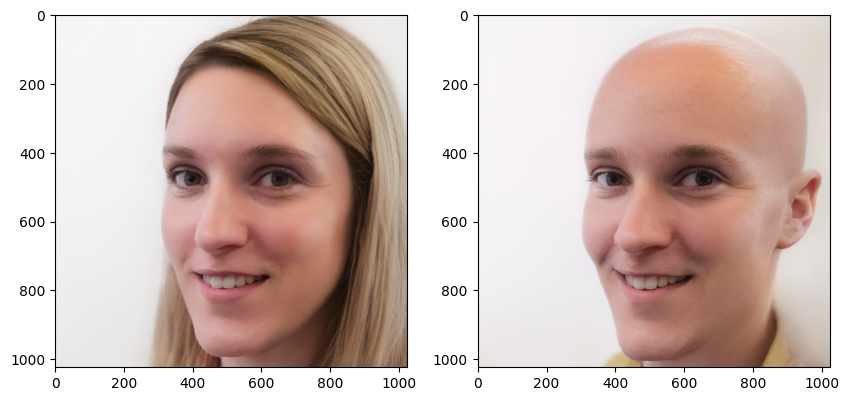

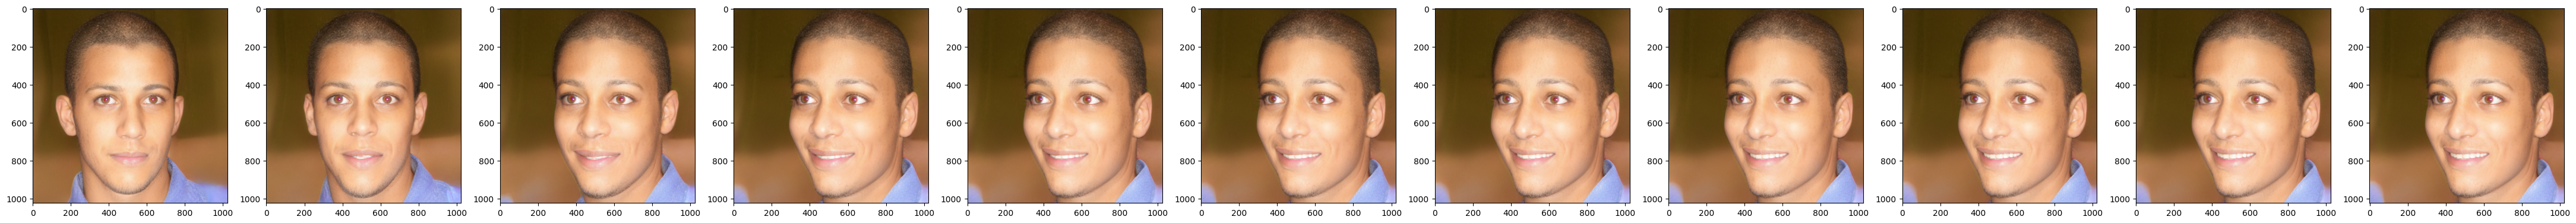

In [ ]:
#global_cond: e.g. 'bowl cut hairstyle' for text_mode; '058728.jpg' for ref_mode
global_cond='058728'
src_feature, edited_hairstyle_img = hairstyle_editing(global_cond=global_cond+'.png')

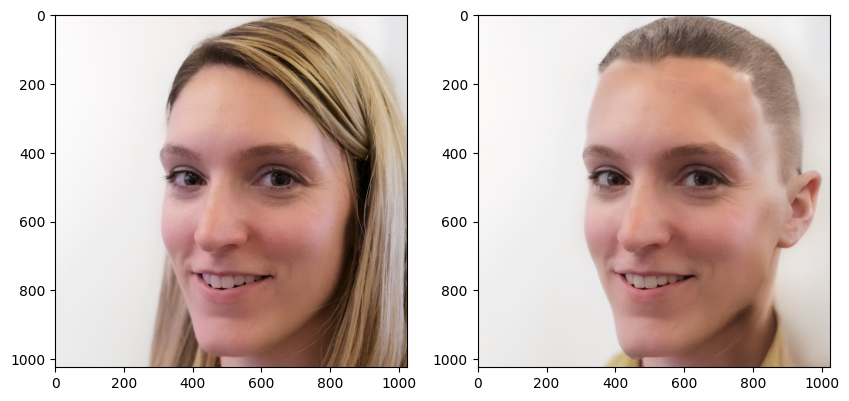

In [ ]:
display_image_list([process_display_input(src_image), process_display_input(edited_hairstyle_img)])

In [ ]:
#Save result
from PIL import Image

img = Image.fromarray(process_display_input(edited_hairstyle_img))
im_path = os.path.join(folder_path_2, f'{src_name}_{global_cond}.png')
img.save(im_path)

# **HAIRCLIP_STYLEGAN3**

In [ ]:
%cd /content/

In [ ]:
folder_path_3 = '/content/output/SG3'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path_3}' created successfully.")
else:
    print(f"Folder '{folder_path_3}' already exists.")

In [ ]:
!rm -r /content/test_HairCLIPv2

In [ ]:
!git clone https://github.com/TamVu02/test_HairCLIPv2 -b sg3_encoder

Cloning into 'test_HairCLIPv2'...
remote: Enumerating objects: 540, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 540 (delta 120), reused 153 (delta 98), pack-reused 356
Receiving objects: 100% (540/540), 37.23 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [ ]:
%cd /content/test_HairCLIPv2

/content/test_HairCLIPv2


In [ ]:
import os
os.listdir()

['models',
 'hairclip_v2_demo.ipynb',
 'scripts',
 'pretrained_models',
 'assets',
 'main_sg3.py',
 'test_images',
 'dnnlib',
 'torch_utils',
 '.git',
 'README.md',
 'criteria',
 'utils',
 'inversion',
 'configs']

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding_sg3 import Embedding_sg3
from scripts.text_proxy import TextProxy
from scripts.ref_proxy import RefProxy
from scripts.feature_blending import hairstyle_feature_blending
from editing.interfacegan.face_editor import FaceEditor
from models.stylegan3.model import GeneratorType
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_sg3_models
from utils.options import Options

In [ ]:
#Load args
opts = Options().parse(jupyter=True)

#Load stylegan3 model for generator
image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
generator, opts_sg3, mean_latent_code, seg = load_sg3_models(opts)

editor = FaceEditor(stylegan_generator=generator.decoder, generator_type=GeneratorType.ALIGNED)

#Change here
edit_direction='Bald' #do not change
min_value=2
max_value=7

re4e = Embedding_sg3(opts, generator, mean_latent_code[0,0])

text_proxy = TextProxy(opts, generator, seg, mean_latent_code)
ref_proxy = RefProxy(opts, generator, seg, re4e)

Loading ReStyle e4e from checkpoint: /content/drive/MyDrive/HairGAN/tam_proposed/restyle_e4e_ffhq.pt
Loading StyleGAN3 generator from path: None
Done!
Model successfully loaded!
Updating SG3 generator with generator from path: /content/drive/MyDrive/HairGAN/HairCLIP/pretrained_models/sg3-r-ffhq-1024.pt
Loading StyleGAN3 generator from path: /content/drive/MyDrive/HairGAN/HairCLIP/pretrained_models/sg3-r-ffhq-1024.pt
Done!


In [ ]:
src_name = '00008'

if not os.path.isfile(os.path.join(opts.src_latent_dir, f"{src_name}.npz")):
    inverted_latent_w_plus, inverted_latent_F = re4e.invert_image_in_FS(image_path=f'{opts.src_img_dir}/{src_name}.png')
    save_latent_path = os.path.join(opts.src_latent_dir, f'{src_name}.npz')
    np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                latent_F=inverted_latent_F.detach().cpu().numpy())

Setting up Perceptual loss...
Loading model from: /content/test_HairCLIPv2/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


In [ ]:
src_latent = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_in']).cuda()
src_feature = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')['latent_F']).cuda()
src_image = image_transform(Image.open(f'{opts.src_img_dir}/{src_name}.png').convert('RGB')).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

In [ ]:
print(f"Performing edit for {edit_direction}...")
edit_images, edit_latents = editor.edit(latents=src_latent,
                                        direction=edit_direction,
                                        factor_range=(min_value, max_value),
                                        user_transforms=None,
                                        apply_user_transformations=False)
print("Done!")
latent_bald=edit_latents[-1]
def prepare_edited_result(edit_images):
  if type(edit_images[0]) == list:
      edit_images = [image[0] for image in edit_images]
  res = np.array(edit_images[0].resize((512, 512)))
  for image in edit_images[1:]:
      res = np.concatenate([res, image.resize((512, 512))], axis=1)
  res = Image.fromarray(res).convert("RGB")
  return res

res = prepare_edited_result(edit_images)
res

In [ ]:
global_cond='00019'
latent_global, visual_global_list=ref_proxy(global_cond+'.png', src_image=src_image, m_style=6)
display_image_list(visual_global_list)

/content/drive/MyDrive/HairGAN/Others/Test_npy/test_sg3_output/W+/00043.npy


  0%|          | 0/200 [00:00<?, ?it/s]

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


ref_loss: 0.2204;: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


In [ ]:
_,src_feature, edited_hairstyle_img = hairstyle_feature_blending(generator, seg, src_latent, src_feature, src_image, input_mask,latent_global=latent_global,latent_bald=latent_bald,n_iter=2)
display_image_list([process_display_input(src_image), process_display_input(edited_hairstyle_img)])

In [ ]:
_

In [ ]:
#Save result
from PIL import Image

save_result_path='/content/drive/MyDrive/HairGAN/Final_HairGAN/output_img'
img = Image.fromarray(process_display_input(edited_hairstyle_img))
im_path = os.path.join(save_result_path, f'{src_name}_{global_cond}_2.png')
img.save(im_path)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0